# Import Libraries

In [204]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import csv
import awkward as ak
import vector
import math
from pandas import *
import pandas as pd
plt.rcParams['figure.dpi'] = 200 

# Inspect Data

In [3]:
tree = uproot.lazy('/Users/vinayakkapoor/Desktop/FCC Data/*.root:events')

# Creating 4-Vectors

In [4]:
muon_p4 = vector.zip({'px': tree['muons.core.p4.px'], 'py': tree['muons.core.p4.py'], 'pz': tree['muons.core.p4.pz'], 'mass':tree['muons.core.p4.mass']})
electron_p4 = vector.zip({'px': tree['electrons.core.p4.px'], 'py': tree['electrons.core.p4.py'], 'pz': tree['electrons.core.p4.pz'], 'mass':tree['electrons.core.p4.mass']})
jets_p4 = vector.zip({'px': tree['pfjets04.core.p4.px'], 'py': tree['pfjets04.core.p4.py'], 'pz': tree['pfjets04.core.p4.pz'], 'mass':tree['pfjets04.core.p4.mass']})

# Object Selection

In [5]:
lepton_p4 = ak.concatenate((muon_p4, electron_p4),axis=1)

### Step 1 (leptons eta cut)

In [6]:
lepton_eta_mask = abs(lepton_p4)<2.5

In [7]:
lepton_p4_1 = lepton_p4[lepton_eta_mask]

### Step 2 (leptons pt cut)

In [8]:
lepton_pt_mask = lepton_p4_1.pt>20

In [9]:
lepton_p4_2 = lepton_p4_1[lepton_pt_mask]

### Step 3 (jets eta cut)

In [10]:
jets_eta_mask = abs(jets_p4)<2.5

In [11]:
jets_p4_1 = jets_p4[jets_eta_mask]

### Step 4 (jets pt cut)

In [12]:
jets_p4_2 = jets_p4_1[jets_p4_1.pt>20]

### Step 5 (leptons delta R cut)

In [13]:
delta_r_lepton_mask = []
for x in range (0,len(lepton_p4_2)):
    delta_r_event_mask = np.zeros((len(jets_p4_2[x]),len(lepton_p4_2[x])))
    for y in range(0, len(jets_p4_2[x])):
        for z in range(0, len(lepton_p4_2[x])):
            dr = jets_p4_1[x][y].deltaR(lepton_p4_2[x][z])
            if dr>0.4: 
                delta_r_event_mask[y][z]=1
    delta_r_event_mask = np.product(delta_r_event_mask, axis=0)
    delta_r_event_mask = delta_r_event_mask.tolist()
    delta_r_lepton_mask.append(delta_r_event_mask)

delta_r_lepton_mask = ak.Array(delta_r_lepton_mask)

In [14]:
lepton_p4_3 = lepton_p4_2[delta_r_lepton_mask==1]

### Step 6 (bjets selection)

In [15]:
bjets_p4 = jets_p4[(tree['pfbTags04.tag']==1)]

# Event Selection

### Step 1 (Choosing 2 oppositely charged leptons) 

In [16]:
n_leptons = ak.num(lepton_p4_3)
two_leptons_mask = n_leptons == 2

In [17]:
two_leptons_p4 = lepton_p4_3[two_leptons_mask]

In [18]:
muons_charges = tree['muons.core.charge']
electrons_charges = tree['electrons.core.charge']
leptons_charges = ak.concatenate((muons_charges,electrons_charges), axis=1)

In [19]:
leptons_charges = leptons_charges[lepton_eta_mask]
leptons_charges = leptons_charges[lepton_pt_mask]
leptons_charges = leptons_charges[delta_r_lepton_mask==1]

In [20]:
two_leptons_charges = leptons_charges[ak.num(leptons_charges)==2]

In [21]:
opposite_sign_leptons_mask = two_leptons_charges[:, 0] != two_leptons_charges[:, 1]
two_leptons_p4_1 = two_leptons_p4[opposite_sign_leptons_mask]

In [22]:
two_leptons_p4_1

<MomentumArray4D [[{x: -42.6, y: 4.73, ... tau: 0}]] type='597 * var * Momentum4...'>

### Step 2 (Choosing 2 bjets)

In [23]:
two_bjets_mask = ak.num(bjets_p4)==2

In [24]:
two_bjets = bjets_p4[two_bjets_mask]

### Step 3 (Invariant mass of ll-bar system event selection)

In [25]:
first_lepton_p4 = two_leptons_p4_1[:,0]
second_lepton_p4 = two_leptons_p4_1[:,1]

In [26]:
sum_leptons_p4 = first_lepton_p4 + second_lepton_p4
llbar_invariant_mass_mask = (sum_leptons_p4.tau>106) | (sum_leptons_p4.tau<76)
two_leptons_p4_2 = two_leptons_p4_1[llbar_invariant_mass_mask]

# Mass Extraction (without event selection)

### Selecting generator level top quarks

In [27]:
is_top = tree['skimmedGenParticles.core.pdgId']==6
top_status = tree['skimmedGenParticles.core.status'][is_top]
top_final_mask = top_status==22

In [28]:
top_p4 = vector.zip({'px': tree['skimmedGenParticles.core.p4.px'], 'py': tree['skimmedGenParticles.core.p4.py'], 'pz': tree['skimmedGenParticles.core.p4.pz'], 'mass':tree['skimmedGenParticles.core.p4.mass']})
top_p4 = top_p4[is_top]
top_p4 = top_p4[top_final_mask]

In [29]:
is_anti_top = tree['skimmedGenParticles.core.pdgId']==-6
anti_top_status = tree['skimmedGenParticles.core.status'][is_anti_top]
anti_top_final_mask = anti_top_status==62

In [30]:
anti_top_p4 = vector.zip({'px': tree['skimmedGenParticles.core.p4.px'], 'py': tree['skimmedGenParticles.core.p4.py'], 'pz': tree['skimmedGenParticles.core.p4.pz'], 'mass':tree['skimmedGenParticles.core.p4.mass']})
anti_top_p4 = anti_top_p4[is_anti_top]
anti_top_p4 = anti_top_p4[anti_top_final_mask]

In [31]:
top_anti_top_p4 = ak.concatenate((top_p4, anti_top_p4),axis=1)

### Plotting the mass distribution for the generator level top quarks

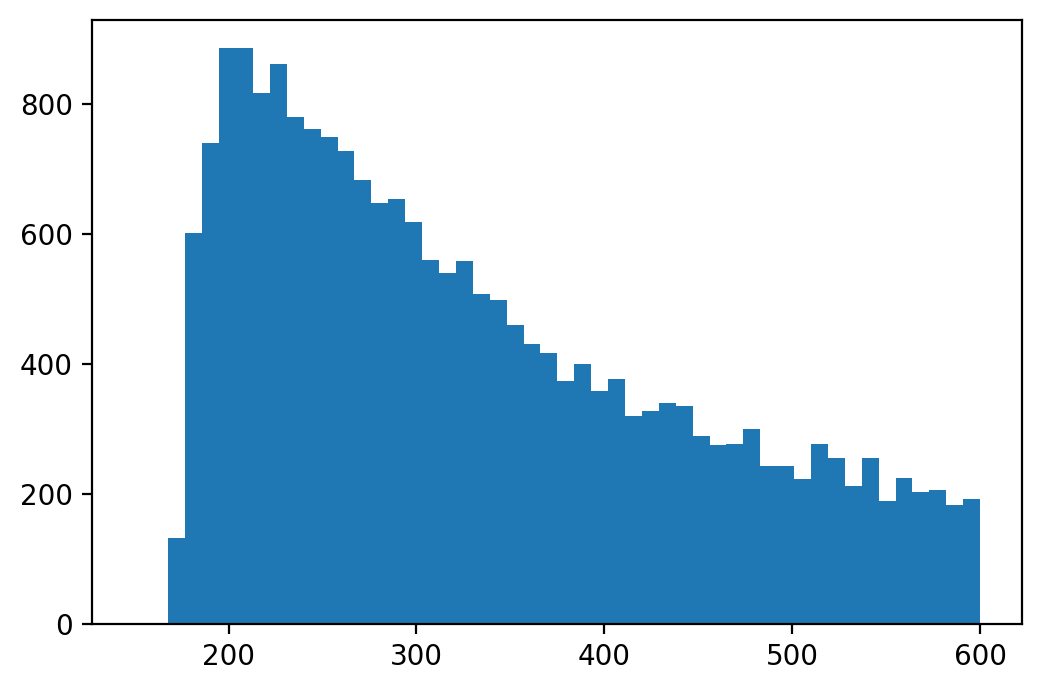

In [32]:
plt.hist(ak.ravel(top_anti_top_p4.energy),bins=50, range=(150,600))
plt.show()

### Fitting a relativistic Breit-Wigner

In [33]:
from scipy.optimize import curve_fit

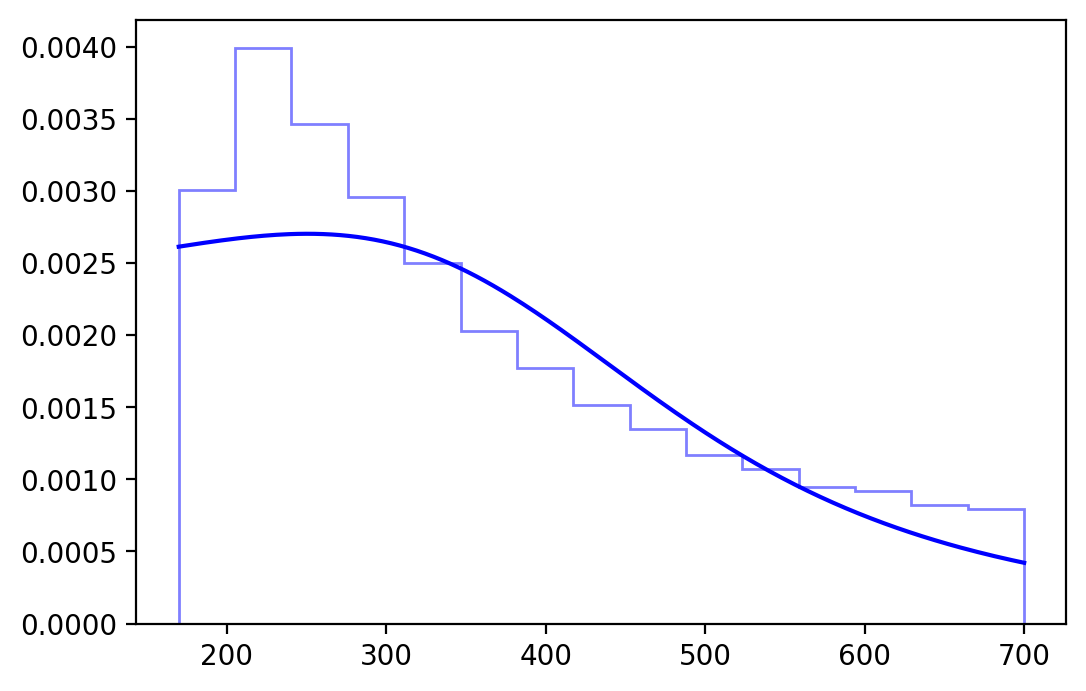

[250.73682262 732.01205327   1.43894374] [[ 7.70739369e+03 -3.58529564e+04 -9.42405090e+00]
 [-3.58529564e+04  1.82651180e+05  4.57174770e+01]
 [-9.42405090e+00  4.57174770e+01  2.36107681e-02]]


In [129]:
def relativistic_breit_wigner(x, resonance_mass, width, normalization):
    gamma = np.sqrt(resonance_mass ** 2 * (resonance_mass ** 2 + width ** 2))
    k = 2.0 * np.sqrt(2) * resonance_mass * width * gamma / (np.pi * np.sqrt(resonance_mass ** 2 + gamma))
    return normalization * k / ((x ** 2 - resonance_mass ** 2) ** 2 + resonance_mass ** 2 * width ** 2)
data = ak.ravel(top_anti_top_p4.energy)
bin_contents, bin_edges = np.histogram(data.to_numpy(), bins=18, range=(160, 650),density= True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
popt, pcov = curve_fit(relativistic_breit_wigner, bin_centers, bin_contents, p0=[200, 20, 30],
                       sigma=np.sqrt(bin_contents))

plt.hist(data, bins=15, range=(170, 700), label='Data',density= True,histtype='step',color='b',alpha=0.5)
x1 = np.linspace(170, 700, 200)
y1 = relativistic_breit_wigner(x1, *popt)
plt.plot(x1, y1, label='Fit', color='b')
plt.show()
print(popt,pcov)

In [35]:
m1 = popt[0]
m1_err = pcov[0,0]**0.5
print("mt =", m1, "±", m1_err)

mt = 250.73682261599862 ± 87.79176324944419


# Mass Extraction (with event selection)

### Applying event selection 

In [36]:
events = top_anti_top_p4

In [37]:
events = events[two_leptons_mask] 
events = events[opposite_sign_leptons_mask]
events = events[llbar_invariant_mass_mask]

In [38]:
bjets_p4 = bjets_p4[two_leptons_mask]
bjets_p4 = bjets_p4[opposite_sign_leptons_mask]
bjets_p4 = bjets_p4[llbar_invariant_mass_mask]
two_bjets_mask = ak.num(bjets_p4)==2

In [39]:
events[two_bjets_mask]

<MomentumArray4D [[{x: -60.4, y: -97, ... tau: 173}]] type='234 * var * Momentum...'>

### Plotting the mass distribution for the top quarks that pass event selection

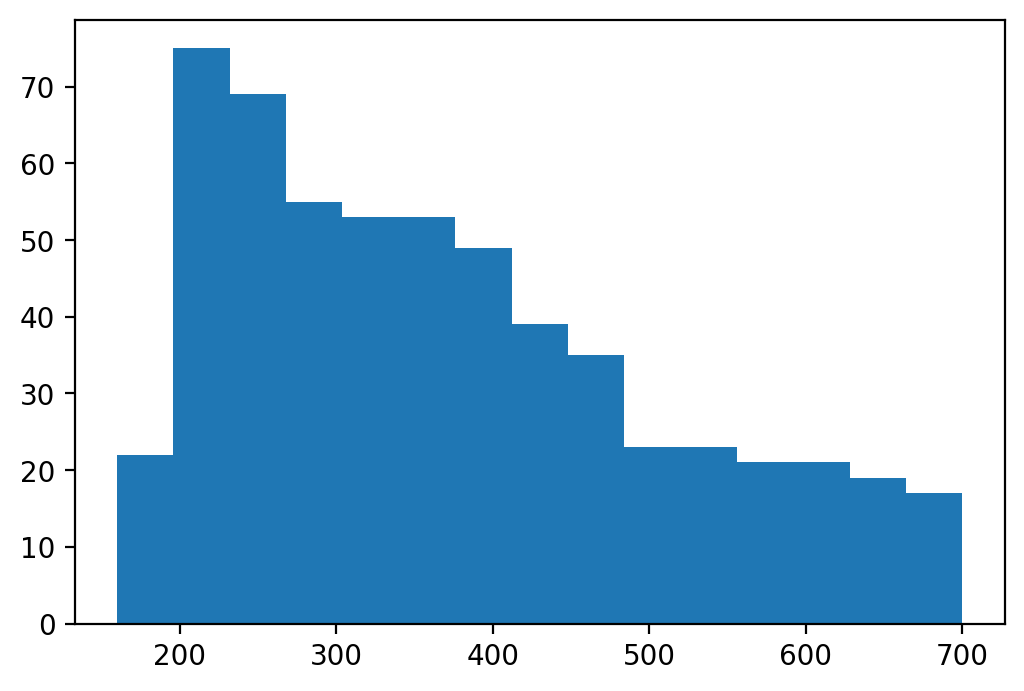

In [40]:
plt.hist(ak.ravel(events.energy),bins=15, range=(160,700))
plt.show()

### Fitting a relativistic Breit-Wigner

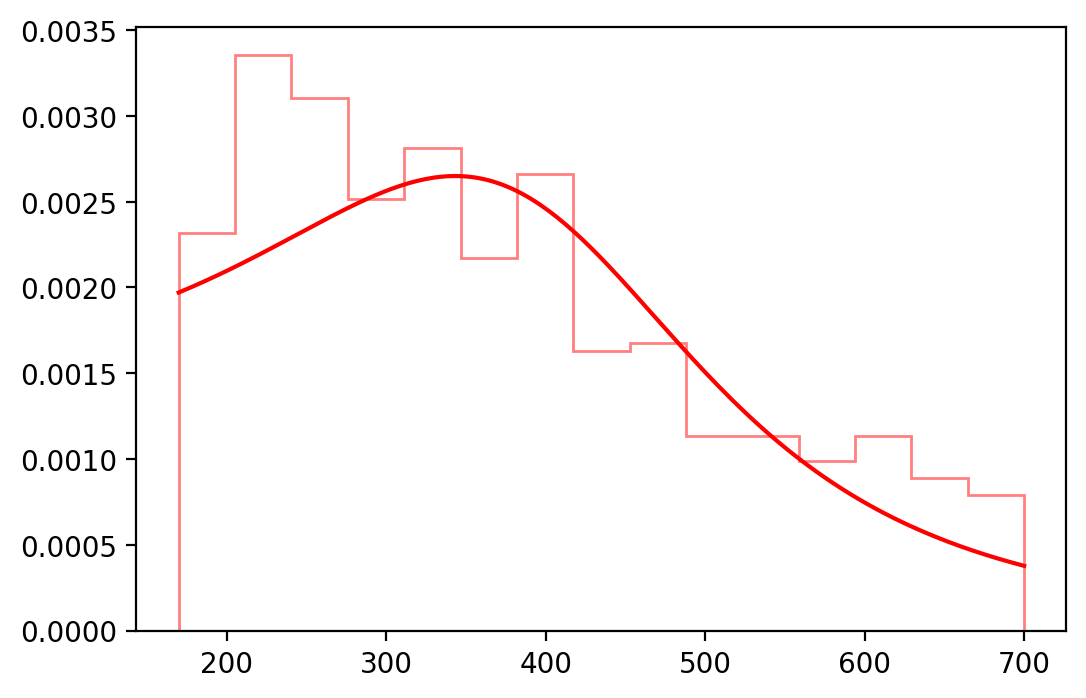

[343.35169875 441.52525128   1.29320334] [[ 8.03809367e+02 -2.37391467e+03 -1.59363348e+00]
 [-2.37391467e+03  1.50667957e+04  8.72898163e+00]
 [-1.59363348e+00  8.72898163e+00  1.55011597e-02]]


In [128]:
def relativistic_breit_wigner(x, resonance_mass, width, normalization):
    gamma = np.sqrt(resonance_mass ** 2 * (resonance_mass ** 2 + width ** 2))
    k = 2.0 * np.sqrt(2) * resonance_mass * width * gamma / (np.pi * np.sqrt(resonance_mass ** 2 + gamma))
    return normalization * k / ((x ** 2 - resonance_mass ** 2) ** 2 + resonance_mass ** 2 * width ** 2)
data = ak.ravel(events.energy)
bin_contents, bin_edges = np.histogram(data.to_numpy(), bins=18, range=(160, 650),density= True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
popt, pcov = curve_fit(relativistic_breit_wigner, bin_centers, bin_contents, p0=[200, 20, 30],
                       sigma=np.sqrt(bin_contents))

plt.hist(data, bins=15, range=(170, 700), label='Data',zorder=0,density= True,histtype='step',color='r',alpha=0.5)
x2 = np.linspace(170, 700, 200)
y2 = relativistic_breit_wigner(x2, *popt)
plt.plot(x2, y2, label='Fit', color='r',zorder=1)
plt.show()

print(popt,pcov)

In [42]:
m2 = popt[0]
m2_err = pcov[0,0]**0.5
print("mt =",m2,"±", m2_err)

mt = 343.3516987478508 ± 28.351532000562766


# Results

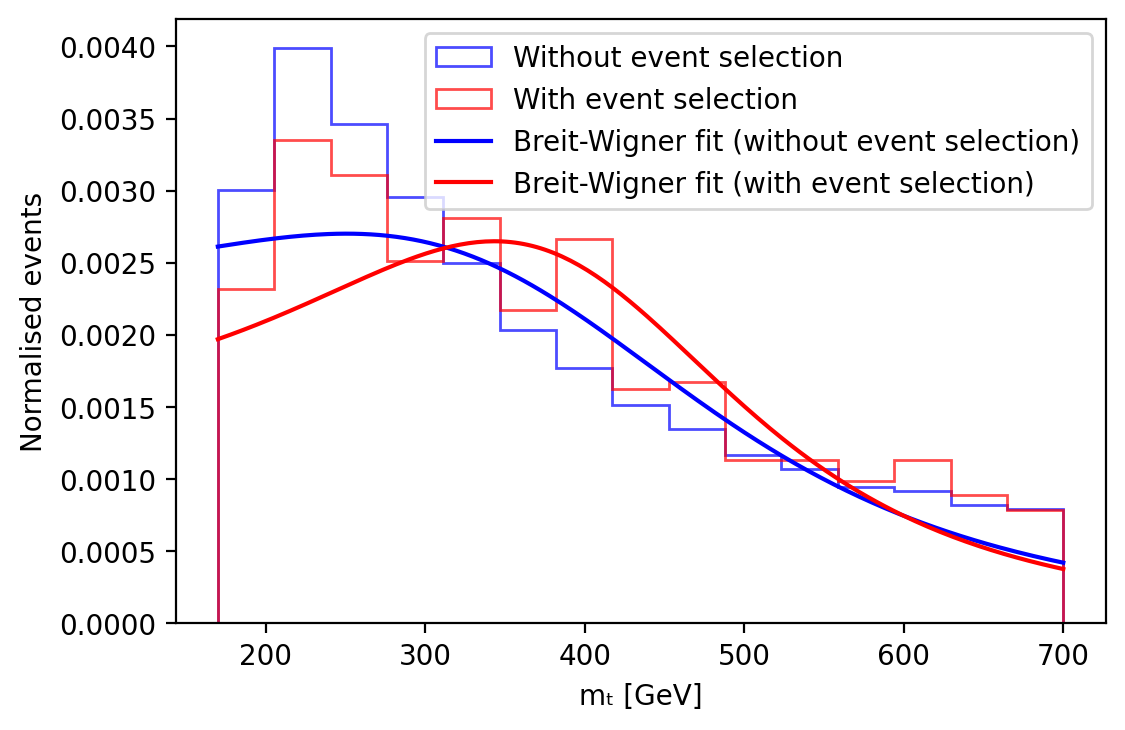

In [45]:
plt.hist(ak.ravel(top_anti_top_p4.energy), histtype='step',bins=15, range=(170, 700),zorder=0,color = 'b', density= True, alpha = 0.7, label = 'Without event selection')
plt.hist(ak.ravel(events.energy), bins=15, histtype='step', range=(170, 700),zorder=1,color = 'r',density= True, alpha = 0.7,label = 'With event selection')
plt.plot(x1, y1, label='Breit-Wigner fit (without event selection)', color='b',zorder=2)
plt.plot(x2, y2, label='Breit-Wigner fit (with event selection)', color='r',zorder=3)
plt.legend(loc='upper right')
plt.xlabel(u'm\u209c [GeV]')
plt.ylabel('Normalised events')
plt.show()


In [112]:
top_masses_no_event_selection = ak.ravel(top_anti_top_p4.energy).tolist()
DF = pd.DataFrame(top_masses_no_event_selection)
DF.to_csv("top_masses_no_event_selection.csv")

In [59]:
top_masses_event_selection = ak.ravel(events.energy).tolist()
DF = pd.DataFrame(top_masses_event_selection)
DF.to_csv("top_masses_event_selection.csv")

In [130]:
data = read_csv("top_masses_no_event_selection.csv")
top_masses_event_no_selection = data['0'].tolist()

In [ ]:
uproot.recreate('new_file.root')


In [ ]:
uproot.recreate('new_file.root')
